In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy import signal
import h5py
import glob
import itertools


## Criacao de uma mascara gaussiana
def gkern(kernlen, std):
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d/np.sum(gkern2d)

## criando uma funcao de filtragem multidimensional
def linearFiltering(img,maskSize,filtType):
  mask            = np.zeros((maskSize,maskSize,1))
  if(filtType == 'gauss'):
    ## relacao W ~ 3*sigma
    sigma         = maskSize/3                                                   
    mask[:,:,0]   = gkern(maskSize,sigma)
    
  elif(filtType == 'mean'):
    ## criando uma mascara de media
    mask[:,:,0]   = (1/(maskSize**2))*np.ones((maskSize,maskSize))
  else:
    print("filter has not found")
    ## se nenhum filtro for escolhido convolui com um impulso
    mask[1,1,:]   = 1
  mask[:,:,0]     = np.rot90(np.rot90(mask[:,:,0]))  
  ## convolui com filtro rotacionado de 180 graus 
  return convolve(img,mask,mode = 'wrap')                                         

def calcErro(imgTruth,imgFiltered,metric = 'PSNR'):
  mse  = ((imgTruth-imgFiltered)**2).sum(axis=0).sum(axis=0)
  if(metric == 'PSNR'):
    psnr = 20*np.log10(135-99 + 10) - 10*np.log10(mse)
  else:
    print('Invalid metric, returning mse')
    psnr = 'NaN'
  return psnr  

def matrix3Scale(image,flag):
  num = (image - image.min(axis=0).min(axis = 0))
  if(flag == 1):
    sup = 35      ## caso positivo considerar imagem truth
  else:
    sup = image.max(axis=0).max(axis = 0) ## caso negativo imagem real
  den = (sup - image.min(axis=0).min(axis = 0))
  return num/den
  

In [0]:
# montagem do repositorio gdrive
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [0]:
# abrindo pasta com arquivos de simulacao
cd ../content/gdrive/My Drive/CYGNO UFJF/Simulation/files

/content/gdrive/My Drive/CYGNO UFJF/Simulation/files


In [0]:
# lista com todos os arquivos .h5
fullFiles  = glob.glob('*.h5')
fullFiles

['db_gen_2019-10-08Run_1000.h5']

In [0]:
## leitura dos arquivos de ruido
file_noise  = '../../noiseFiles/noise_data.h5'
fn          = h5py.File(file_noise,'r')
ped         = fn['mean']
## run 817
ped         = ped[:,:,1]

In [0]:
## Leitura dos dados
## tamanho dos pacotes de imgs processados 
batch_size   = 32 
## limitantes superiores e inferiores
boundsup  = 135-99 + 10
boundinf  = 85 - 99 -10
## outputs
erro      = []
contraste = []
for filename in fullFiles:
  ## leitura do h5
  f          = h5py.File(filename,'r')
  ## matriz com imagens ruidosas
  objXtrain  = f['x_train']
  ## matriz com imagens truth correspondentes
  objYtrain  = f['y_train']
  ## vetor com intensidade correspondente
  objAlpha   = f['alpha']
  ## tamanho das matrizes #imagens x MxN
  size       = objXtrain.shape
  ## dimensao da imagem quadrada por default
  imdim      = int(np.sqrt(size[1]))
  ## adquirindo imagem pedestal centrada na origem
  p          = ped[1024-imdim//2:1024+imdim//2,1024-imdim//2:1024+imdim//2]
  ## vetores de varredura dos batches
  idx        = list(range(0,size[0],batch_size))
  idy        = list(range(batch_size,size[0],batch_size))
  idy.append(size[0])
  
  ## leitura dos batches
  
  for i,j in zip(idx,idy):
    ## reshaping para transformar batches de imagens em dim x dim x batch_size
    imReal   =  objXtrain[i:j,:].T.reshape(imdim,imdim,j-i)
    imTruth  =  objYtrain[i:j,:].T.reshape(imdim,imdim,j-i)
    alpha    =  objAlpha[i:j]
    ## normalizar pico para 1
    scale    = imTruth.max(axis = 0).max(axis=0)
    ## multiplica por alpha/pico -> alpha*I
    imTruth  = imTruth*(alpha/scale)
    ## replicando valor do ruido para subtrair
    multiPed = np.repeat(p[:, :, np.newaxis], imReal.shape[2], axis=2)
    ## removendo pedestal
    imNoPad = imReal-multiPed
    ## saturando imagem
    imNoPad[imNoPad>boundsup] = boundsup
    imNoPad[imNoPad<boundinf] = boundinf
    imFiltered = linearFiltering(imNoPad,35,'mean')
    erro.append(calcErro(imTruth,imFiltered,'PSNR'))
    contraste.append(alpha)
    
    
erro      = list(itertools.chain.from_iterable(erro))
contraste = list(itertools.chain.from_iterable(contraste))  
  

In [0]:
erro

[-3.4331845443273465,
 -17.83425228072216,
 -7.569003661400153,
 -15.12199976613936,
 -19.392796325156063,
 -18.960360312248646,
 -6.038213421510058,
 -10.570004370049531,
 -18.970874734382683,
 -9.539011730640077,
 -17.780247192188533,
 -16.557301235540876,
 -6.242248657243195,
 -15.873045287504617,
 -16.174401178967024,
 -17.406842491635423,
 -20.10745620934071,
 -13.436774138094279,
 -18.385606956401695,
 -18.365086055714265,
 -18.062079765593992,
 -16.398196326728794,
 -10.434469584653534,
 -14.722730073846115,
 -17.974068505510196,
 -12.75521670232974,
 2.66536828177054,
 -16.41874897953935,
 -17.836086084368397,
 -12.08522744419355,
 -19.758117647657848,
 -1.589030480955742,
 4.391963803057578,
 -18.41862176195125,
 -17.51657095765193,
 -14.348601446629267,
 -22.002064813438025,
 2.2771547100813336,
 -8.857004101772027,
 -19.38313255032522,
 -16.48318515252827,
 -3.866968189170443,
 -1.3969840919500527,
 -18.22377947680196,
 -9.698947899871719,
 -13.378435862715754,
 -21.66219735

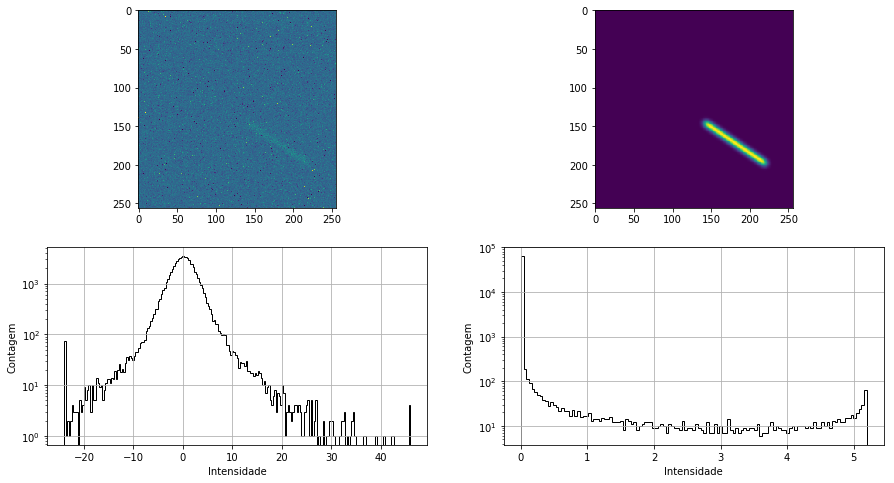

In [0]:
imNumber = 5
fig,ax = plt.subplots(2,2,figsize = (15,8))
ax = ax.ravel()
ax[0].imshow(imNoPad[:,:,imNumber],cmap = 'viridis')
#ax[1].imshow(imTeste,cmap = 'viridis',vmax = boundsup,vmin = boundinf)
#axx,ayy,azz = ax[4].hist(imTeste.ravel(),bins = 'scott',histtype='step',color = 'black')
#ax[4].set_xlim([boundinf,boundsup])
ax[1].imshow(imTruth[:,:,imNumber],cmap = 'viridis')
#ax[0].colorbar()
axx,ayy,azz = ax[2].hist(imNoPad[:,:,imNumber].ravel(),bins = 'scott',histtype='step',color = 'black')
axx,ayy,azz = ax[3].hist(imTruth[:,:,imNumber].ravel(),bins = 'scott',histtype='step',color = 'black')
#ax[1].set_xlim([-100,100])
#ax[1].set_ylim([0,30000])
ax[2].grid()
ax[3].grid()
ax[2].set_xlabel('Intensidade')
ax[3].set_xlabel('Intensidade')
ax[2].set_ylabel('Contagem')
ax[3].set_ylabel('Contagem')
ax[2].set_yscale('log')
ax[3].set_yscale('log')


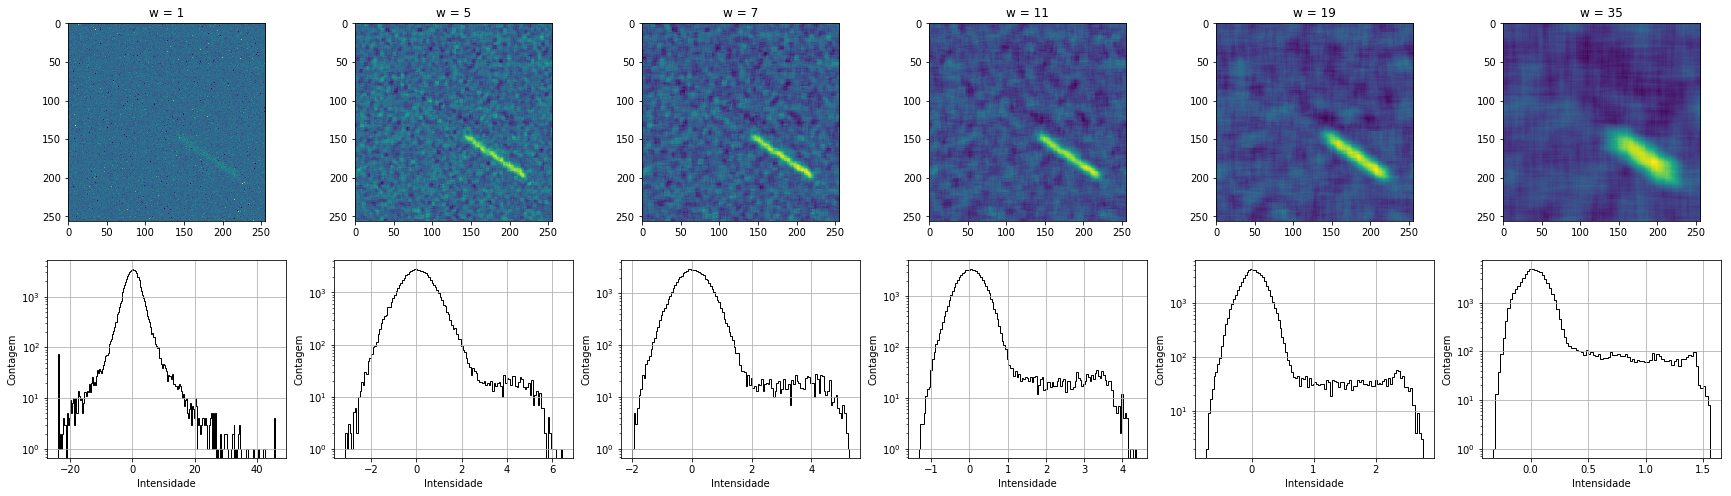

In [0]:
windows   = [1,5,7,11,19,35]
fig,axes  = plt.subplots(2,len(windows),figsize = (30,8))
axes      = axes.T
for w,ax in zip(windows,axes):
  imFilt = linearFiltering(imNoPad,w,'mean')[:,:,imNumber]
  ax[0].imshow(imFilt,cmap = 'viridis')
  ax[0].set_title('w = ' + str(w))
  ax[1].hist(imFilt.ravel(),bins = 'scott',histtype='step',color = 'black')
  ax[1].grid()
  ax[1].set_yscale('log')
  ax[1].set_xlabel('Intensidade')
  ax[1].set_ylabel('Contagem')
  
  



In [0]:
nSigma = 1.0
imT    = imTruth>alpha*(np.exp(-nSigma))

(110, 140)

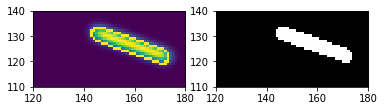

In [0]:

#xx,yy  = np.where(np.diff(imT[:,:,1])!= 0)
xv,yv = np.where((np.diff(imT[:,:,1],axis = 0)== True))
xh,yh = np.where((np.diff(imT[:,:,1],axis = 1)== True))
aux    = imTruth[:,:,1]
aux[xv,yv] = alpha[1]
aux[xh,yh] = alpha[1]



(110, 140)

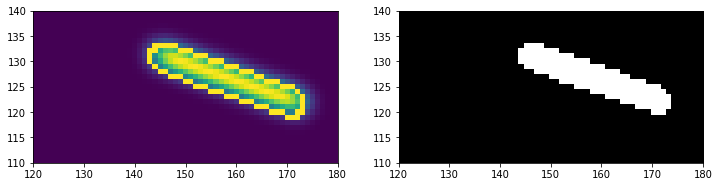

In [0]:
fig,ax = plt.subplots(1,2,figsize = (12,12))
ax[0].imshow(aux,cmap = 'viridis')
ax[0].set_xlim([120,180])
ax[0].set_ylim([110,140])
ax[1].imshow(imT[:,:,1],cmap = 'gray')
ax[1].set_xlim([120,180])
ax[1].set_ylim([110,140])
